# SpecSim Examples

Examples of using SpecSim to perform simulations of the DESI multifiber spectrograph.

The latest documentation for SpecSim is at [specsim.readthedocs.io](http://specsim.readthedocs.io/en/latest/fiberloss.html).

In order to run these examples, you will need to have [SpecSim installed](http://specsim.readthedocs.io/en/stable/install.html) and [$DESIMODEL set](http://specsim.readthedocs.io/en/stable/config.html#desi-configuration).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord

## Initialization

You will usually only need to import a single module to use specsim:

In [3]:
import specsim.simulator

A simulator uses a configuration file to customize its behavior.  You will normally use the default DESI configuration that is provided with the package, like this:

In [4]:
desi = specsim.simulator.Simulator('desi', num_fibers=500)

The `num_fibers` parameter is required.  Pass `verbose=True` to see details of the configuration process.

Note that the DESI configuration refers to files in `$DESIMODEL/data/`, so you will need to have `$DESIMODEL` set appropriately.  See [here](http://specsim.readthedocs.io/en/latest/config.html#desi-configuration) for details.

There is also a `test` configuration, used for running automated unit tests, and an `eboss` configuration is under development.  Information about changing the default configuration is [here](http://specsim.readthedocs.io/en/latest/config.html).

## Simulation Basics

The `desi.simulate()` method runs a simulation, and takes several optional per-fiber arrays as input parameters. Any array parameters that are not specified will use the configuration default for all fibers.

For example, to simulate with configuration defaults for everything (which is generally not very useful):

In [5]:
desi.simulate()

In this example, you have simulated 500 identical point-like objects with the spectrum of an AB-standard with magnitude 22. All fibers are located at the same focal-plane position (x,y) = (-70.7,+70.7) mm specified in the config file, which is obviously not very realistic.  See below for examples of specify each fiber's location and details on how the simulated response varies with position.

Note that there is no return value from `desi.simulate()`. Instead, simulation results are stored in several astropy Tables that are allocated once and then re-used whenever `simulate()` is called.  For example:

In [6]:
print desi.simulated[:3]

wavelength    source_flux [500]     ... read_noise_electrons_z [500]
 Angstrom   erg / (Angstrom cm2 s)  ...                             
---------- ------------------------ ... ----------------------------
    3550.0 1.3699e-17 .. 1.3699e-17 ...                   0.0 .. 0.0
    3550.1 1.3698e-17 .. 1.3698e-17 ...                   0.0 .. 0.0
    3550.2 1.3698e-17 .. 1.3698e-17 ...                   0.0 .. 0.0


Tables are indexed by wavelength and include units. See [here](http://specsim.readthedocs.io/en/latest/output.html) for details on output table columns.  Here is an example of calculating the median SNR per pixel in each camera:

In [7]:
def print_median_snr(fiber=0, sim=desi):
    for output in sim.camera_output:
        name = output.meta['name']
        pixel_size = output.meta['pixel_size']
        snr = (output['num_source_electrons'][:, fiber] /
               np.sqrt(output['variance_electrons'][:, fiber]))
        print('{0} median SNR = {1:.3f} / {2:.1f}'.format(name, np.median(snr), pixel_size))
        
print_median_snr()

b median SNR = 1.137 / 0.5 Angstrom
r median SNR = 0.917 / 0.5 Angstrom
z median SNR = 0.722 / 0.5 Angstrom


Simulation outputs can be saved to a FITS file using, for example, `desi.save("output.fits")`.  Simulation results for individual fibers can also be plotted using:

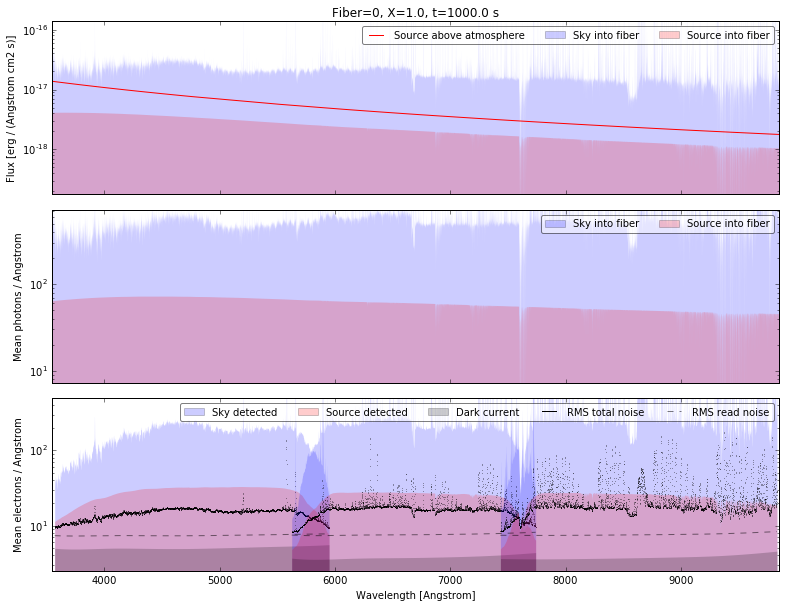

In [8]:
desi.plot(fiber=0)

To zoom in on an interesting feature, use the optional `wavelength_min` and `wavelength_max` parameters:

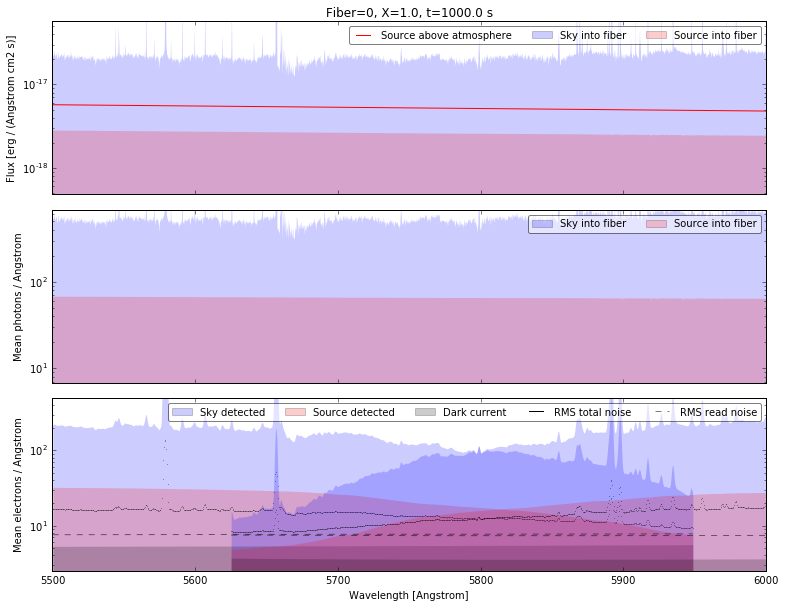

In [9]:
desi.plot(fiber=0, wavelength_min=5500 * u.Angstrom, wavelength_max=6000 * u.Angstrom)

## Observing Parameters

The full set of observing parameters are specified in the `observation` and `atmosphere` sections of the config file, but a few can also be changed at run time, e.g.

In [10]:
desi.observation.exposure_time = 2000 * u.s
desi.simulate()
print_median_snr()

b median SNR = 1.701 / 0.5 Angstrom
r median SNR = 1.365 / 0.5 Angstrom
z median SNR = 1.076 / 0.5 Angstrom


In [11]:
desi.atmosphere.airmass = 1.5
desi.simulate()
print_median_snr()

b median SNR = 1.597 / 0.5 Angstrom
r median SNR = 1.331 / 0.5 Angstrom
z median SNR = 1.046 / 0.5 Angstrom


In [12]:
desi.observation.exposure_time = 1000 * u.s
desi.atmosphere.airmass = 1.0
desi.simulate()
print_median_snr()

b median SNR = 1.137 / 0.5 Angstrom
r median SNR = 0.917 / 0.5 Angstrom
z median SNR = 0.722 / 0.5 Angstrom


Note that airmass can only be specified directly like this when fiber positions are specified in the focal plane, rather than on the sky.  Otherwise, airmass is derived from the telesope pointing: see the example below.

Also note that changes to the seeing will not have any effect unless the GalSim method of fiberloss calcualtions is selected: see the example below.

## Source Flux

Use the `source_fluxes` optional parameter to specify the spectrum of each observed object above the atmosphere. Spectra should be tabulated on the `desi.simulated['wavelength']` grid and have valid flux units. For example, to simulate the same constant flux for all fibers:

In [13]:
num_wlen = len(desi.simulated['wavelength'])
flux = np.ones((desi.num_fibers, num_wlen)) * 6e-17 * u.erg / (u.Angstrom * u.s * u.cm ** 2)
desi.simulate(source_fluxes=flux)

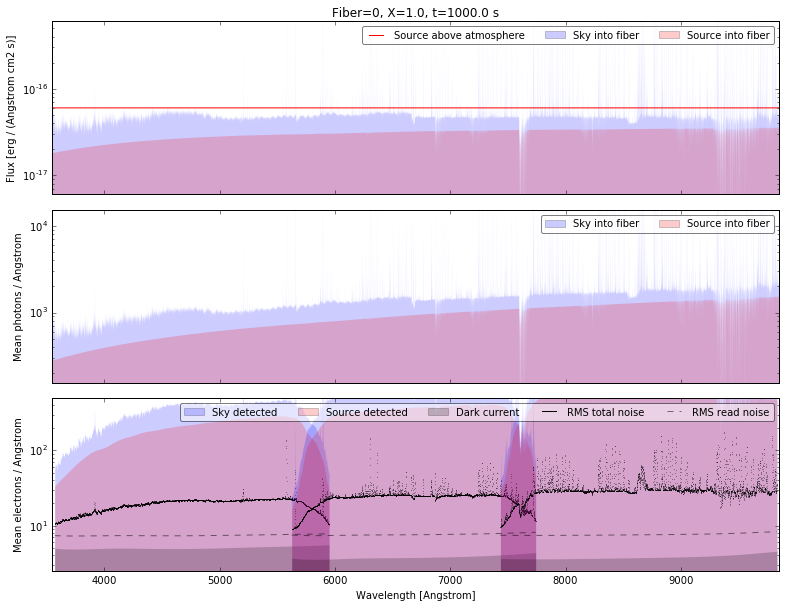

In [14]:
desi.plot(fiber=0)

## Fiber Positions

The position of each fiber can either be specified using (x,y) coordinates in the focal plane or else by specifying (ra, dec) coordinates on the sky.  In both cases, all positions must have suitable units and lie within the telescope field of view.

To specify (x,y) locations on the focal plane, use the `focal_positions` optional parameter to pass an array with dimensions (num_fibers, 2).  For example, to assign random positions to all fibers:

In [15]:
def generate_fiber_positions(sim=desi, seed=123):
    gen = np.random.RandomState(seed)
    focal_r = (
        np.sqrt(gen.uniform(size=sim.num_fibers)) * sim.instrument.field_radius)
    phi = 2 * np.pi * gen.uniform(size=sim.num_fibers)
    return (np.vstack([np.cos(phi), np.sin(phi)]) * focal_r).T

In [16]:
xy = generate_fiber_positions()
desi.simulate(source_fluxes=flux, focal_positions=xy)

With the default configuration, only the sky response will vary over the focal plane as a result of the plate-scale dependence on radius. The next section describes how to add realistic variations in the source response.

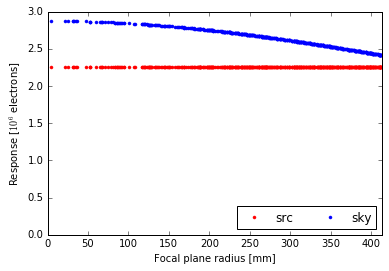

In [17]:
def plot_response_vs_radius(sim=desi, ymax=3.):
    """Calculate total number of source and sky electrons detected.
    """
    nsrc = np.zeros(sim.num_fibers)
    nsky = np.zeros(sim.num_fibers)
    for band in 'brz':
        nsrc += sim.simulated['num_source_electrons_{0}'.format(band)].sum(axis=0)
        nsky += sim.simulated['num_sky_electrons_{0}'.format(band)].sum(axis=0)
    focal_r = np.sqrt(sim.focal_x ** 2 + sim.focal_y ** 2).to(u.mm).value

    plt.plot(focal_r, 1e-6 * nsrc, 'r.', label='src')
    plt.plot(focal_r, 1e-6 * nsky, 'b.', label='sky')
    plt.legend(loc='lower right', ncol=2, numpoints=1)
    plt.xlabel('Focal plane radius [mm]')
    plt.ylabel('Response [$10^6$ electrons]')
    plt.xlim(0., sim.instrument.field_radius.to(u.mm).value)
    plt.ylim(0., ymax)
    
plot_response_vs_radius()

Alternatively, specify sky positions for each fiber:

In [18]:
def generate_sky_positions(sim=desi, seed=123):
    gen = np.random.RandomState(seed)
    # Generate random targets in a (RA, DEC) box centered on the current pointing.
    nsrc = sim.num_fibers
    ra_center = sim.observation.pointing.ra
    dec_center = sim.observation.pointing.dec
    sky = SkyCoord(ra=ra_center + gen.uniform(-1, 1, nsrc) * u.deg,
                   dec=dec_center + gen.uniform(-1, 1, nsrc) * u.deg,
                   frame='icrs')
    return sky

sky = generate_sky_positions()

In [19]:
desi.simulate(source_fluxes=flux, sky_positions=sky)

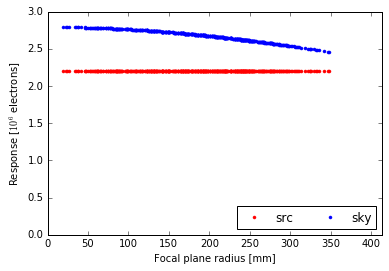

In [20]:
plot_response_vs_radius()

After calling `simulate()`, the actual focal-plane (x,y) coordinates are stored in arrays `desi.focal_x` and `desi.focal_y` with units:

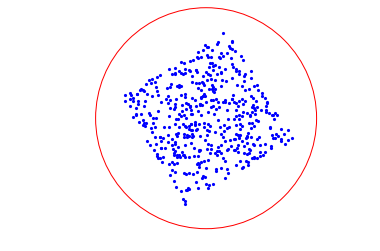

In [21]:
def plot_focal_xy(sim=desi):
    plt.scatter(sim.focal_x.to(u.mm).value, sim.focal_y.to(u.mm).value, s=10, lw=0)
    r = 1.05 * sim.instrument.field_radius.to(u.mm).value
    plt.xlim(-1.01 * r, +1.01 * r)
    plt.ylim(-1.01 * r, +1.01 * r)
    plt.gca().set_aspect('equal', 'datalim')
    plt.gca().add_artist(plt.Circle((0, 0), r, color='r', fill=False))
    plt.axis('off')
    
plot_focal_xy()

In this mode of positioning targets, the transformation from sky to focal plane depends on a number of auxillary observing parameters that you can adjust, for example:

In [22]:
desi.observation.exposure_start

<Time object: scale='utc' format='mjd' value=55000.5>

In [23]:
desi.observation.pointing

<SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 0.0)>

In [24]:
desi.observation.observing_model

<AltAz Frame (obstime=55000.505787, location=(-1994502.6043061386, -5037538.54232911, 3358104.9969029757) m, pressure=788.060134183 hPa, temperature=15.0 deg_C, relative_humidity=0.0, obswl=0.67 micron)>

After the simulation, some derived parameters are available including the airmass:

In [25]:
desi.atmosphere.airmass

<Quantity 1.261536790127223>

In [26]:
desi.observation.boresight_altaz.alt

<Latitude 51.52275031791419 deg>

Changing observing parameters will change these derived parameters:

In [27]:
desi.observation.exposure_start += 2 * u.hour

In [28]:
desi.simulate(source_fluxes=flux, sky_positions=sky)

In [29]:
desi.atmosphere.airmass

<Quantity 1.1779290966048621>

Note that the focal-plane (x,y) coordinates have also changed now:

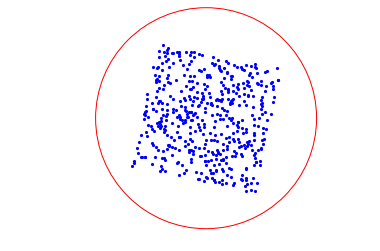

In [30]:
plot_focal_xy()

## Fiber Acceptance Fractions

Fiber acceptance refers to the fraction of photons incident on the focal plane from an astrophysical source that enter the fiber.  For more information see [here](http://specsim.readthedocs.io/en/latest/fiberloss.html).

### Predefined Source Types

The default mode of operation is to read precomputed fiberloss fractions from files in `$DESIMODEL/throughput/`.  The file used for each fiber is based on its assigned source type. In this example, we assign random types to each fiber:

In [31]:
source_types = random.choice(('lrg', 'elg', 'qso'), desi.num_fibers)

In [32]:
desi.simulate(source_fluxes=flux, focal_positions=xy, source_types=source_types)

The fiberloss fractions used in the simulation are tabulated in `desi.simulated['fiberloss']`. Note that the `sky` and `perfect` types are equivalent and so are `qso` and `star`, so there are only 4 distinct fiberloss types currently available:

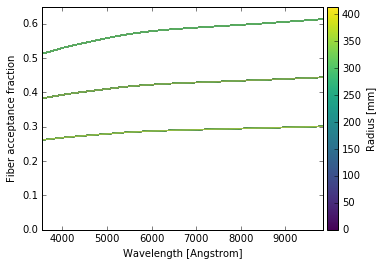

In [33]:
def plot_fiberloss(sim=desi):
    wlen = sim.simulated['wavelength'].to(u.Angstrom).value
    rvalues = np.sqrt(sim.focal_x ** 2 + sim.focal_y ** 2).to(u.mm).value
    norm = matplotlib.colors.Normalize(
        vmin=0., vmax=sim.instrument.field_radius.to(u.mm).value)
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('viridis'))
    for fiber in range(sim.num_fibers):
        plt.plot(wlen, sim.simulated['fiberloss'][:, fiber], ls='-', alpha=0.2,
                 color=sm.to_rgba(rvalues[fiber]))
    sm._A = []
    plt.colorbar(sm, pad=0.01).set_label('Radius [mm]')
    plt.ylim(0., 0.65)
    plt.xlim(wlen[0], wlen[-1])
    plt.xlabel('Wavelength [{0}]'.format(sim.simulated['wavelength'].unit))
    plt.ylabel('Fiber acceptance fraction')

plot_fiberloss()

We now have different signal levels for each source type, but still no variation in the source response over the focal plane:

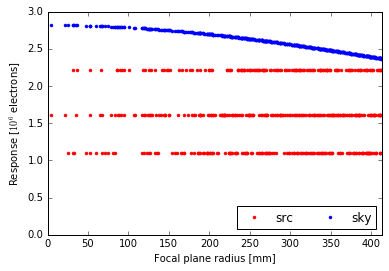

In [34]:
plot_response_vs_radius()

### Fiberloss calculated with GalSim

The instrument config includes the expected blur and centroid offset as a function of wavelength and radius on the focal plane.  In addition, a correlated pattern of random (achromatic) offsets simulates imperfect fiber positioning. The per-fiber fiber acceptance fraction involves a convolution of the atmospheric and instrumental PSFs with the source profile on the sky, which specsim can calculate using the [GalSim package](https://github.com/GalSim-developers/GalSim/blob/master/README.md).  To enable this mode, use:

In [35]:
desi.instrument.fiberloss_method = 'galsim'

The `source_types` parameter is now ignored and, instead, the source size and profile on the sky are taken from the `source.profile` configuration parameters.  The response to this identical source now varies across the focal plane due to variations in the optical PSF and plate scales, and random positioning errors:

In [36]:
desi.simulate(source_fluxes=flux, focal_positions=xy)

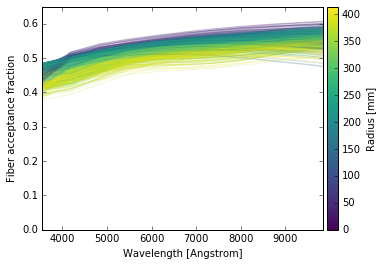

In [37]:
plot_fiberloss()

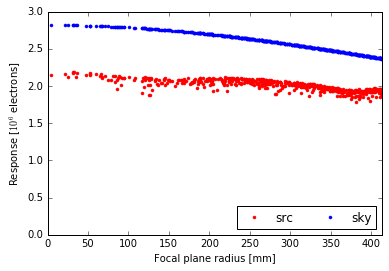

In [38]:
plot_response_vs_radius()

In this mode, sources are modeled as a superposition of three components (with no relative offsets): galaxy disk (Sersic n=1), galaxy bulge (Sersic n=4) and point like.  Each source is specified with the following parameters:
 - `source_fraction[nsrc, 2]`: disk and bulge fractions (remainder is point like)
 - `source_half_light_radius[nsrc, 2]`: disk and bulge half-light radius in arcseconds.
 - `source_minor_major_axis_ratio[nsrc, 2]`: disk and bulge ellipticity specified as the axis ratio 0 < b/a <= 1.
 - `source_position_angle[nsrc, 2]`: disk and bulge orientation of the major axis in degrees, measured counter
    clockwise relative to the +x axis.
    
Note that all 3 components are assumed to have the same centroid, but the disk and bulge have independent rotation angles.

In this example, we generate suitable random parameters for each source:

In [39]:
def generate_sources(seed=123):
    gen = np.random.RandomState(seed)
    nsrc = desi.num_fibers
    source_fraction = np.zeros((nsrc, 2))
    source_half_light_radius = np.zeros((nsrc, 2))
    source_minor_major_axis_ratio = np.zeros((nsrc, 2))
    source_position_angle = 360. * gen.normal(size=(nsrc, 2))
    for i, source_type in enumerate(source_types):
        if source_type == 'qso':
            # Default source_fraction is 100% point like.
            pass
        if source_type == 'elg':
            # Disk only with random size and ellipticity.
            source_fraction[i] = (1, 0)
            hlr = 0.45 * np.exp(0.25 * gen.normal())
            source_half_light_radius[i] = (hlr, 0)
            q = np.minimum(0.99, 0.50 * np.exp(0.15 * gen.normal()))
            source_minor_major_axis_ratio[i] = (q, 0)
        elif source_type == 'lrg':
            # Bulge only with random size and ellipticity.
            source_fraction[i] = (0, 1)
            hlr = 0.80 * np.exp(0.25 * gen.normal())
            source_half_light_radius[i] = (0, hlr)
            q = np.minimum(0.99, 0.16 * np.exp(0.15 * gen.normal()))
            source_minor_major_axis_ratio[i] = (0, q)
    return dict(
        source_fraction=source_fraction,
        source_half_light_radius=source_half_light_radius,
        source_minor_major_axis_ratio=source_minor_major_axis_ratio,
        source_position_angle=source_position_angle)

sources = generate_sources()

In [40]:
desi.simulate(source_fluxes=flux, focal_positions=xy, **sources)

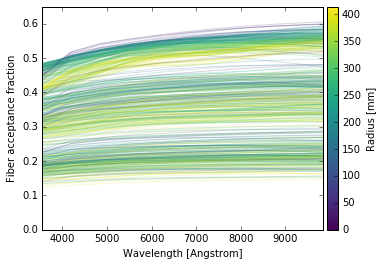

In [41]:
plot_fiberloss()

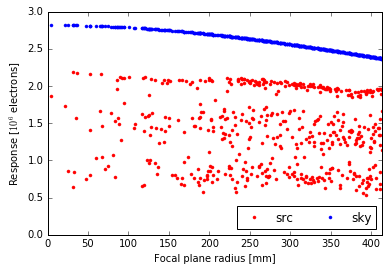

In [42]:
plot_response_vs_radius()

Changes to the seeing are only taken into account when using this GalSim mode:

In [43]:
desi.atmosphere.seeing_fwhm_ref = 1.3 * u.arcsec
desi.simulate(source_fluxes=flux, focal_positions=xy, **sources)

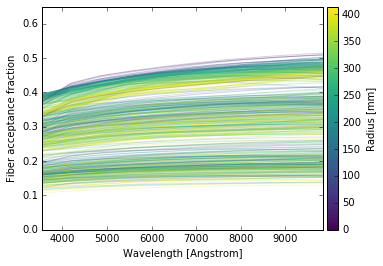

In [44]:
plot_fiberloss()

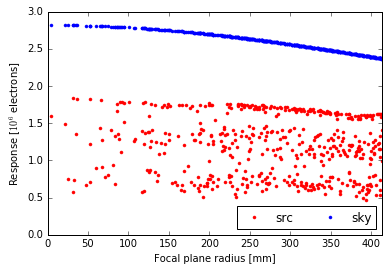

In [45]:
plot_response_vs_radius()

### Fiberloss calculated externally

Finally, you can provide an array of fiberloss values tabulated externally (which does not require having GalSim installed):

In [46]:
def generate_fiberloss(seed=123):
    gen = np.random.RandomState(seed)
    nsrc = desi.num_fibers
    nwlen = len(desi.simulated['wavelength'])
    fiberloss = np.empty((nsrc, nwlen))
    fiberloss[:] = 0.3 + 0.05 * gen.normal(size=(nsrc, 1))
    return fiberloss
    
fiberloss = generate_fiberloss()

In this case, the instrument and source config parameters used by GalSim are ignored and the fiber positions are only used to scale the sky response (so the caller is responsible for ensuring that positions are treated consistently):

In [47]:
desi.simulate(source_fluxes=flux, focal_positions=xy, fiber_acceptance_fraction=fiberloss)

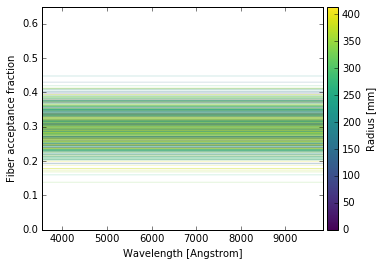

In [48]:
plot_fiberloss()

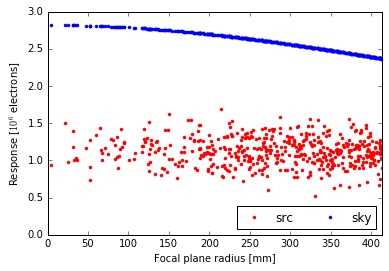

In [49]:
plot_response_vs_radius()

## Calibration Exposures

Calibration exposures can be simulated by passing an array of surface brightness values to the `simulate` method.  In this case, the source and fiberloss inputs are ignored, and no atmospheric emission or extinction are applied.  For example, to simulate a flat calibration:

In [50]:
flat_lamp = np.ones((desi.num_fibers, num_wlen)) * 2e-13 * u.erg / (u.Angstrom * u.s * u.cm ** 2 * u.arcsec ** 2)
desi.observation.exposure_time = 10 * u.s
desi.simulate(calibration_surface_brightness=flat_lamp, focal_positions=xy)

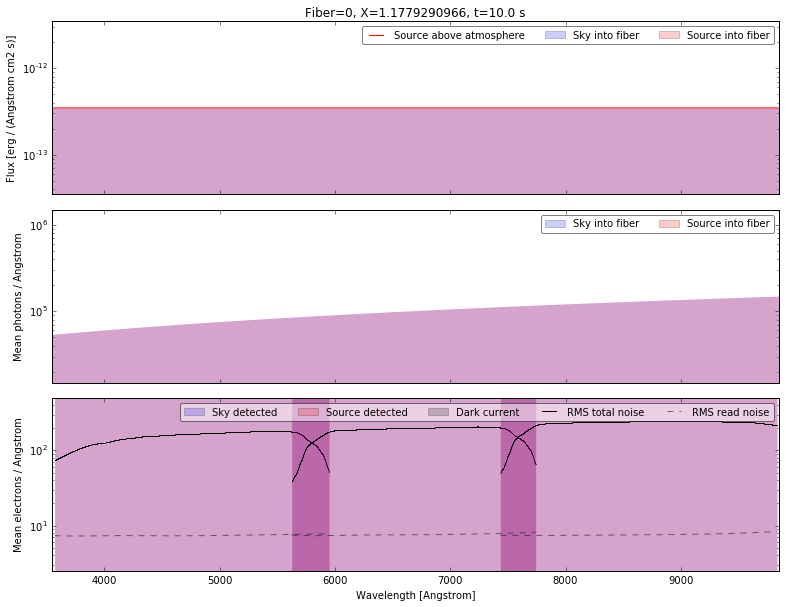

In [51]:
desi.plot(fiber=0)

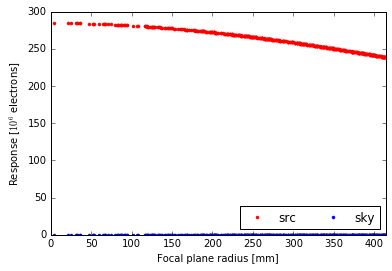

In [52]:
plot_response_vs_radius(ymax=300)

Narrow lines in an arc calibration can be simulated by setting a single bin in the input array to contain their total surface brightness. This effectively treats the lines as narrow boxcars, but you can reduce the boxcar width by using a finer simulation wavelength grid (`wavelength_grid.step` in the YAML config file) at the expense of memory and speed.  For example:

In [53]:
arc_lamp = np.zeros((desi.num_fibers, num_wlen)) * 2e-13 * u.erg / (u.Angstrom * u.s * u.cm ** 2 * u.arcsec ** 2)
arc_lamp[:, 1000::2000] = 1e-11 * u.erg / (u.Angstrom * u.s * u.cm ** 2 * u.arcsec ** 2)
desi.observation.exposure_time = 5 * u.s
desi.simulate(calibration_surface_brightness=arc_lamp, focal_positions=xy)

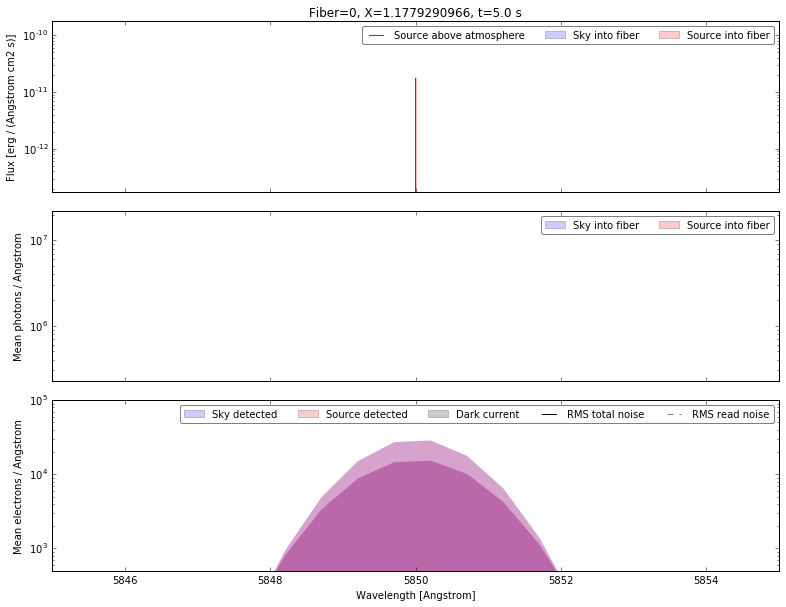

In [54]:
desi.plot(fiber=0, wavelength_min=5845 * u.Angstrom, wavelength_max=5855 * u.Angstrom, min_electrons=500)

Note that the middle plot looks empty but actually contains a narrow spike that is not visible with the plotting method used.